# Compute the power spectrum of an Illustris map and compare to theory

In [1]:
import numpy as np 
import torch 
import matplotlib.pyplot as plt

boxsize = 25 #This is specific to the full-resolution maps from CAMELS, units are h^-1Mpc, Corresponds to (256, 256)
maps = np.load('/groups/mlprojects/dm_diffusion/data/Maps_Mcdm_IllustrisTNG_LH_z=0.00.npy')

In [2]:
def power(x,x2=None):
    """
    Parameters
    ---------------------
    x: the input field, in torch tensor
    
    x2: the second field for cross correlations, if set None, then just compute the auto-correlation of x
    
    ---------------------
    Compute power spectra of input fields
    Each field should have batch and channel dimensions followed by spatial
    dimensions. Powers are summed over channels, and averaged over batches.

    Power is not normalized. Wavevectors are in unit of the fundamental
    frequency of the input.
    
    source code adapted from 
    https://nbodykit.readthedocs.io/en/latest/_modules/nbodykit/algorithms/fftpower.html#FFTBase
    """
    signal_ndim = x.dim() - 2
    signal_size = x.shape[-signal_ndim:]
    
    kmax = min(s for s in signal_size) // 2
    even = x.shape[-1] % 2 == 0
    
    x = torch.fft.rfftn(x, s=signal_size)  # new version broke BC
    if x2 is None:
        x2 = x
    else:
        x2 = torch.fft.rfftn(x2, s=signal_size)
    P = x * x2.conj()
    
    P = P.mean(dim=0)
    P = P.sum(dim=0)
    
    del x, x2
    
    k = [torch.arange(d, dtype=torch.float32, device=P.device)
         for d in P.shape]
    k = [j - len(j) * (j > len(j) // 2) for j in k[:-1]] + [k[-1]]
    k = torch.meshgrid(*k,indexing="ij")
    k = torch.stack(k, dim=0)
    k = k.norm(p=2, dim=0)

    N = torch.full_like(P, 2, dtype=torch.int32)
    N[..., 0] = 1
    if even:
        N[..., -1] = 1

    k = k.flatten().real
    P = P.flatten().real
    N = N.flatten().real

    kbin = k.ceil().to(torch.int32)
    k = torch.bincount(kbin, weights=k * N)
    P = torch.bincount(kbin, weights=P * N)
    N = torch.bincount(kbin, weights=N).round().to(torch.int32)
    del kbin

    # drop k=0 mode and cut at kmax (smallest Nyquist)
    k = k[1:1+kmax]
    P = P[1:1+kmax]
    N = N[1:1+kmax]

    k /= N
    P /= N

    return k, P, N

def pk(fields):
    kss,pkss,nss = [],[],[]
    for field in fields:
        ks,pks,ns = power(field[None])#add 1 batch
        kss.append(ks)
        pkss.append(pks)
        nss.append(ns)
    return torch.stack(kss,dim=0),torch.stack(pkss,dim=0),torch.stack(nss,dim=0)

k_conversion = 2*np.pi/boxsize
def compute_pk(field, field_b=None,):
    # Assumes field has shape (1,1,Npixels, Npixels)
    assert len(field.shape) == 4
    if field_b is not None:
        assert len(field_b.shape) == 4
        k, pk, _ = power(
            torch.Tensor(field/np.sum(field)),
            torch.Tensor(field_b/np.sum(field_b)),
        )
    else:
        k, pk, _ = power(
            torch.Tensor(field/np.sum(field)),
        )
    k *= k_conversion
    pk *= boxsize**2
    return k, pk

In [3]:
import jax_cosmo as jc 
from jax_cosmo.power import linear_matter_power, nonlinear_matter_power

cosmo = jc.Planck15(Omega_b=0.05, Omega_c=0.25, sigma8=0.8)
print(cosmo.Omega_c)

ModuleNotFoundError: No module named 'jax_cosmo'

In [54]:
# from cosmicpy import cosmology

cosmo = jc.Planck15(Omega_b=0.05, Omega_c=0.25, sigma8=0.8)
pk_theory = linear_matter_power(cosmo, k.cpu().numpy(), a=1.)
pk_theory_nl = nonlinear_matter_power(cosmo, k.cpu().numpy(), a=1.)
# cosmo = cosmology(Omega_m=0.3, sigma8=0.1)
# pk_theory = cosmology.pk(k)

/srv/tmp/brandon/miniconda3/envs/torch/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/srv/tmp/brandon/miniconda3/envs/torch/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/srv/tmp/brandon/miniconda3/

In [4]:
pks = []
for i in range(100):
    map = maps[i][None, None, :, :] # B, C, H, W
    # map = (map - maps.mean()) / maps.mean()
    # map = map - maps.mean()
    k, pk = compute_pk(map)
    pks.append(pk)

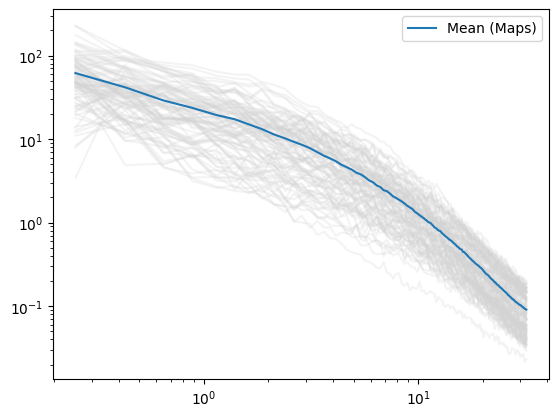

In [6]:
for i in range(100):
    plt.loglog(k, pks[i], color='lightgrey', alpha=0.25)
plt.loglog(k, np.mean(pks, axis=0), label='Mean (Maps)')
# plt.loglog(k, pk_theory, label='Theory', linestyle='dotted')
# plt.loglog(k, pk_theory_nl, label='Theory (Nonlinear)')
# plt.loglog(k, pk_theory_nl / np.mean(pks, axis=0))
plt.legend()
plt.show()